# Estimating Pi

The following example should highlight, how one can convert most Python classes that take arguments into a ZnTrack stage.
Here we take on an example to Estimate the value Pi.
The original notebook can be found here https://gist.github.com/SamTov/907aebbc6c36a242e15e3745a91989eb .
There were only a few changes made:

    1. convert parameters to `zn.params()`
    2. convert results to `zn.outs()`
    3. modify the `__init__` method for the adding the parameters to the class
    4. Add a `run` method that does the heavy lifting for us and runs the expensive computation

That's it - now we can inherit from `zntrack.Node` and we can even stay inside the Jupyter notebook.

In [5]:
# We work in a temporary directory to avoid cluttering the current directory
import os
import tempfile

temp_dir = tempfile.TemporaryDirectory()
os.chdir(temp_dir.name)

In [6]:
%%writefile mcpipy.py

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import zntrack

class MCPi(zntrack.Node):
    """
    A class to study Monte Carlo sampling as applied to
    the computation of Pi.

    Attributes
    ----------
    coordinates : np.ndarray
            Coordinates of points plotted.
    n_circle_points : int
            Number of points in the circle
    n_points : int
            Total number of points.
    """

    n_points: int = zntrack.params()

    coordinates: np.ndarray = zntrack.outs()
    n_circle_points: int = zntrack.outs()

    def run(self):
        """
        Draw N points from a normal distribution.

        N : int
                Number of points to draw.
        """
        self.coordinates = np.random.random(size=(self.n_points, 2))
        self._circle_points()  # compute the number of points in the circle.

    def _circle_points(self):
        """
        Compute the number of points in the circle.
        """
        radial_values = np.linalg.norm(self.coordinates, axis=1)
        self.n_circle_points = len(list(filter(lambda x: x <= 1, radial_values)))

    def plot_image(self, axs=None):
        """
        Plot the circle, square, and points.

        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        circle = plt.Circle((0, 0), 1, fill=False)
        square = patches.Rectangle((0, 0), 1, 1, fill=False)
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)
        ax.spines.left.set_position("zero")
        ax.spines.right.set_color("none")
        ax.spines.bottom.set_position("zero")
        ax.spines.top.set_color("none")
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("left")
        ax.add_patch(circle)
        ax.add_patch(square)
        ax.set_aspect("equal")
        plt.show()

    def plot_sampling(self, axs=None, show: bool = False):
        """
        Plot the result of the sampling.

        Parameters
        ----------
        axs : mpl.axis
                An axis object to plot to if desired.
        """
        coordinates = np.array(self.coordinates)
        circle = plt.Circle((0, 0), 1, fill=False, linewidth=3, edgecolor="k", zorder=10)
        square = patches.Rectangle(
            (0, 0), 1, 1, fill=False, linewidth=3, edgecolor="k", zorder=10
        )
        if axs is None:
            ax = plt.gca()
        else:
            ax = axs
        ax.set_xlim(-0.0, 1.0)
        ax.set_ylim(-0.0, 1.0)
        ax.spines.left.set_position("zero")
        ax.spines.right.set_color("none")
        ax.spines.bottom.set_position("zero")
        ax.spines.top.set_color("none")
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("left")
        ax.plot(coordinates[:, 0], coordinates[:, 1], ".")
        inner_points = np.array(
            list(filter(lambda x: np.linalg.norm(x) <= 1, coordinates))
        )
        ax.plot(inner_points[:, 0], inner_points[:, 1], "r.")
        ax.add_patch(circle)
        ax.add_patch(square)
        ax.set_title(
            f"N: {self.n_points} ; $\pi$ = {4 * self.n_circle_points / self.n_points}"
        )
        ax.set_aspect("equal")

        if show:
            plt.show()

Writing mcpipy.py


Now let us define pi estimates with different numbers of points and run them all.

In [7]:
from mcpipy import MCPi

import zntrack

In [10]:
!git init

!dvc init -q

Initialized empty Git repository in /private/var/folders/81/0x90c4yd0cz6tz104v9syf580000gn/T/tmp0t2p5zny/.git/


In [11]:
project = zntrack.Project()
with project:
    mcpi = MCPi(n_points=50000)
project.repro()

2024-10-17 08:53:57,689 - INFO: Saving params.yaml


100%|██████████| 1/1 [00:00<00:00, 508.40it/s]


Running stage 'MCPi':
> zntrack run mcpipy.MCPi --name MCPi
Generating lock file 'dvc.lock'
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add nodes/MCPi/.gitignore dvc.lock

To enable auto staging, run:

	dvc config core.autostage true
Use `dvc push` to send your updates to remote storage.


In [12]:
!git add .

!git commit -m "initial commit"

[main (root-commit) 9535b3d] initial commit
 11 files changed, 162 insertions(+)
 create mode 100644 .dvc/.gitignore
 create mode 100644 .dvc/config
 create mode 100644 .dvcignore
 create mode 100644 __pycache__/mcpipy.cpython-311.pyc
 create mode 100644 dvc.lock
 create mode 100644 dvc.yaml
 create mode 100644 mcpipy.py
 create mode 100644 nodes/MCPi/.gitignore
 create mode 100644 nodes/MCPi/node-meta.json
 create mode 100644 params.yaml
 create mode 100644 zntrack.json


In [7]:
with project.create_experiment(name="n=10000"):
    mcpi.n_points = 10000
with project.create_experiment(name="n=1000"):
    mcpi.n_points = 1000
with project.create_experiment(name="n=100"):
    mcpi.n_points = 100

project.run_exp()

[NbConvertApp] Converting notebook estimate_pi_with_mc.ipynb to script
[NbConvertApp] Writing 5352 bytes to estimate_pi_with_mc.py


Queued experiment 'n=10000' for future execution.


[NbConvertApp] Converting notebook estimate_pi_with_mc.ipynb to script
[NbConvertApp] Writing 5352 bytes to estimate_pi_with_mc.py


Queued experiment 'n=1000' for future execution.


[NbConvertApp] Converting notebook estimate_pi_with_mc.ipynb to script


Queued experiment 'n=100' for future execution.


[NbConvertApp] Writing 5352 bytes to estimate_pi_with_mc.py


Following logs for all queued experiments. Use Ctrl+C to stop following logs (experiment execution will continue).

Running stage 'MCPi':
> zntrack run src.MCPi.MCPi --name MCPi
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add dvc.yaml dvc.lock params.yaml

To enable auto staging, run:

	dvc config core.autostage true
Running stage 'MCPi':
> zntrack run src.MCPi.MCPi --name MCPi
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add dvc.yaml dvc.lock params.yaml

To enable auto staging, run:

	dvc config core.autostage true
Running stage 'MCPi':
> zntrack run src.MCPi.MCPi --name MCPi
Updating lock file 'dvc.lock'

To track the changes with git, run:

	git add dvc.yaml params.yaml dvc.lock

To enable auto staging, run:

	dvc config core.autostage true

Ran experiment(s): 
To apply the results of an experiment to your workspace run:

	dvc exp apply <exp>

To promote an experiment to a Git branch run:

	dvc exp branch <exp> <branch>



We can now see our experiments and the respective hash values:


Let us load them and plot them after each other. Because all the calculations where already performed, this is simply loading the correct result files.

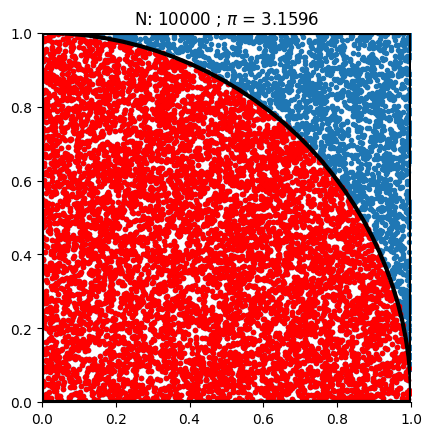

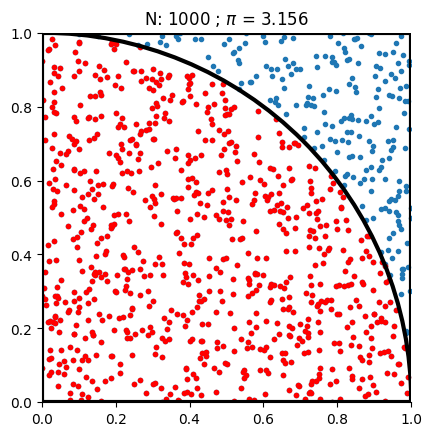

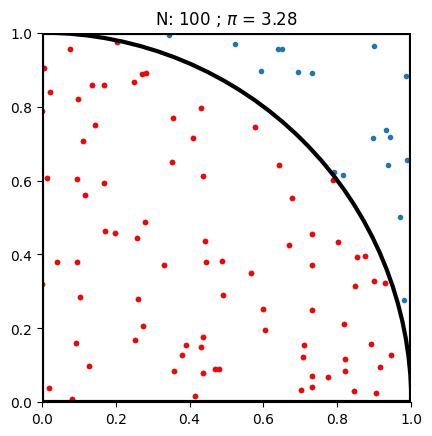

In [8]:
MCPi.from_rev(rev="n=10000").plot_sampling(show=True)
MCPi.from_rev(rev="n=1000").plot_sampling(show=True)
MCPi.from_rev(rev="n=100").plot_sampling(show=True)

In [13]:
MCPi.from_rev().coordinates

array([[0.73709681, 0.86074431],
       [0.22390598, 0.44795612],
       [0.53639366, 0.92740253],
       ...,
       [0.2768875 , 0.3622939 ],
       [0.59488187, 0.87269338],
       [0.75722943, 0.6005775 ]])

In [14]:
temp_dir.cleanup()